# X Education - Lead Scoring Model

#### This notebook is built for <font color = blue>X Education</font> - an education company which sells online courses to industry professionals.</font>

### Business Goal
Current lead conversion rate of X education is low at around 30% which needs to be improved.

Categorize the Leads into hot and cold by assigning a lead score to each of the open leads <u>to improve the Lead Conversion Ratio</u>. The CEO of X Education has set the business goal of targeting lead conversion rate of around 80%.


#### This notebook contains following steps which organizes our analysis and inferences for easy consumption driving <u>data-driven  decision making</u> for HELP International CEO.

- Section 1: Exploratory Data Analysis
- Section 2: Data Preparation
- Section 3: Model Training
- Section 4: Model Validation
- Section 5: Making predictions on the test set
- Section 6: Generate Lead Score and Export the result dataset
- Section 7: Final Recommendations

***
>- `Created by: Chandrashekhar V Purandare, Maganuru Basavaraju`
>- `Creation Date: 26-Feb-2010`
>- `Modified by:Chandrashekhar V Purandare`
>- `Last Modified Date: 2-Mar-2020`
>- `Comments: Notebook creation and validation`
***

### Pre-Req 1: Load required libraries 

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import required libraries for data manupulation
import numpy as np
import pandas as pd
import itertools

# Import required libraries for data visulization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import required libraries for Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

# Import required libraries for data scaling, ML modelling and model verification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

### Pre-Req 2: Set Pandas display options and format

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

### Pre-Req 3: Reusable Functions

Function to get numeric columns list

In [3]:
def get_numeric_columns(df):
    return list(df.select_dtypes(include=[np.number]).columns)

Function to get categorial columns list

In [4]:
def get_categorial_columns(df):
    return list(df.select_dtypes(exclude=[np.number]).columns)

Defining the binary map function to convert "Yes = 1" and "No = 0"

In [5]:
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

Function to check the Variance Variance Inflation Factor (VIF)

In [6]:
def check_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

Function to plot ROC curve

In [7]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

## Section 1: Exploratortory Data Analysis

### Step 1: Reading and Understanding Leads data
##### <u>Important Assumption</u>: The CSV file - "Leads.csv", containing the Leads data is located in the same folder in which this Jupyter notebook is present.

#### 1.1 Load the leads data

In [8]:
df_leads = pd.DataFrame(pd.read_csv('Leads.csv'))
# Validate the dataset loaded correctly 
df_leads.head(5)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.00,0,0.00,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.00,15.00,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.00,674,2.50,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.00,15.00,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.00,1532,2.00,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.00,20.00,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.00,305,1.00,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.00,17.00,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.00,1428,1.00,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.00,18.00,No,No,Modified


#### 1.2 Check the strcture of the data (Normal routine checks)

In [9]:
# Check the total number of rows and columns present in dataset
print("Leads dataset contains {0} columns and {1} rows.".format(df_leads.shape[1], df_leads.shape[0]))

Leads dataset contains 37 columns and 9240 rows.


In [10]:
# Get the descriptive statistics for leads dataset
df_leads.describe().T

,count,mean,std,min,25%,50%,75%,max
Lead Number,9240.00,617188.44,23406.00,579533.00,596484.50,615479.00,637387.25,660737.00
Converted,9240.00,0.39,0.49,0.00,0.00,0.00,1.00,1.00
TotalVisits,9103.00,3.45,4.85,0.00,1.00,3.00,5.00,251.00
Total Time Spent on Website,9240.00,487.70,548.02,0.00,12.00,248.00,936.00,2272.00
Page Views Per Visit,9103.00,2.36,2.16,0.00,1.00,2.00,3.00,55.00
Asymmetrique Activity Score,5022.00,14.31,1.39,7.00,14.00,14.00,15.00,18.00
Asymmetrique Profile Score,5022.00,16.34,1.81,11.00,15.00,16.00,18.00,20.00


In [11]:
# Get the info about dataset
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

#### 1.3 Check the current conversion rate for leads

In [12]:
# Current coversion rate for leads dataframe
print("Current Leads conversion rate is : {}%".format(round((sum(df_leads.Converted)/len(df_leads.index))*100,2)))

Current Leads conversion rate is : 38.54%


### Step 2 : Data Cleaning

#### 2.1 Duplicate data analysis

In [13]:
# Verify if any duplicate rows exists for all columns
df_leads.loc[df_leads.duplicated()]

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity


In [14]:
#checking if there are no duplicate pospect exists
sum(df_leads.duplicated(subset = 'Prospect ID')) == 0

True

<b><u>Analysis Summary</u></b>: It is noticed from the above output of duplicate checks performned, that there are <u>no duplicate rows</u> in the data which needs to be corrected. Also, there are no duplicate prospects exists in the dataset.

#### 2.2 Handle "Select" level present in categorial variables

When we observed the Leads dataset, we found that there are "Select" values for many columns such as,
- Specialization
- How did you hear about X Education
- Lead Profile
- City

The reason for having this "Select" value for these columns is user did not select any option from the drop-down list while filling the Online Application Form. Since, these are non-mandatory fields for form, system has stored the "Select" value for those columns, when user did not make any explicit selection from the list. This means user has left the value for these columns as blank (Null). 

Hence, we have decided to replace the "Select" value in these columns with Null (NaN).

In [15]:
# Converting "Select" values to NaN.
df_leads = df_leads.replace('Select', np.nan)

#### 2.3 Check for missing data

In [16]:
# Get the percentage of null values for all columns in Leads dataframe
round(100*(df_leads.isnull().sum()/len(df_leads.index)), 2)

Prospect ID                                     0.00 
Lead Number                                     0.00 
Lead Origin                                     0.00 
Lead Source                                     0.39 
Do Not Email                                    0.00 
Do Not Call                                     0.00 
Converted                                       0.00 
TotalVisits                                     1.48 
Total Time Spent on Website                     0.00 
Page Views Per Visit                            1.48 
Last Activity                                   1.11 
Country                                         26.63
Specialization                                  36.58
How did you hear about X Education              78.46
What is your current occupation                 29.11
What matters most to you in choosing a course   29.32
Search                                          0.00 
Magazine                                        0.00 
Newspaper Article           

#### Check for columns which are having high percentage (>40%) of missing values

In [17]:
df_leads.loc[:,list(round(100*(df_leads.isnull().sum()/len(df_leads.index)), 2)>40)].columns

Index(['How did you hear about X Education', 'Lead Quality', 'Lead Profile',
       'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score'],
      dtype='object')

"How did you hear about X Education" and "Lead Profile" contains more that 70% of null values and it is not recommended to impute such a large null values with standard statistical imputation techniques. 

Hence, we have decided to drop these columns.

In [18]:
# Drop the columns having more than 70% Null values
df_leads = df_leads.drop(df_leads.loc[:,list(round(100*(df_leads.isnull().sum()/len(df_leads.index)), 2)>70)].columns, 1)
# Verify the shape of dataframe after dropping these 2 columns
df_leads.shape

(9240, 35)

Lets analyze Asymmetrique Activity Index, Asymmetrique Activity Score, Asymmetrique Profile Index and Asymmetrique Profile Score columns 

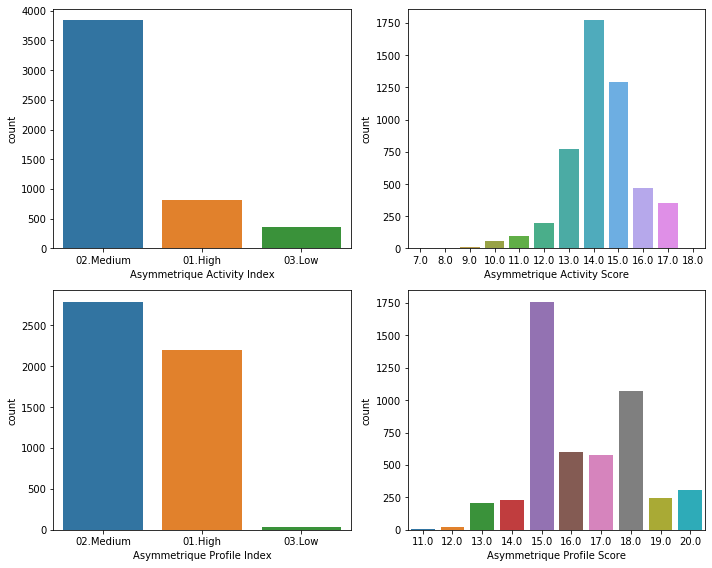

In [19]:
fig, axs = plt.subplots(2,2, figsize = (10,8))
plt1 = sns.countplot(df_leads['Asymmetrique Activity Index'], ax = axs[0,0])
plt2 = sns.countplot(df_leads['Asymmetrique Activity Score'], ax = axs[0,1])
plt3 = sns.countplot(df_leads['Asymmetrique Profile Index'], ax = axs[1,0])
plt4 = sns.countplot(df_leads['Asymmetrique Profile Score'], ax = axs[1,1])
plt.tight_layout()

Asymmetrique Activity Index, Asymmetrique Activity Score, Asymmetrique Profile Index and Asymmetrique Profile Score columns has ~45% null values and after analyzing above bar plots it is clear that there is too much variation for the values of these columns. 

In addition, it is not clear from Data Dictionary how to calculate these scope and index and logic behind generation of these values. Hence, there is no robust way to impute these columns.

Hence, we decided to drop these columns.

In [20]:
df_leads = df_leads.drop(['Asymmetrique Activity Index','Asymmetrique Activity Score','Asymmetrique Profile Index','Asymmetrique Profile Score'],1)
# Verify the shape of dataframe after dropping these 4 columns
df_leads.shape

(9240, 31)

Next we have analyzed the "Lead Quality" column.

As mentioned in the Data Dictionary, Lead Quality indicates the quality of lead based on the data and intuition the employee who has been assigned to the lead. Lead Quality contains 51.59% of missing (Null) values. However, this column seems to be having higher business importance, hence, we have decided not to drop this column and rather impute the values by studying the data for this column. Lets have a detailed look at this column data.

In [21]:
df_leads['Lead Quality'].value_counts()

Might be             1560
Not Sure             1092
High in Relevance    637 
Worst                601 
Low in Relevance     583 
Name: Lead Quality, dtype: int64

Since, Lead Quality column is filled by the assigned employee based on the data and intuition, it is safe to impute "Not Sure" value for null values in this column. 

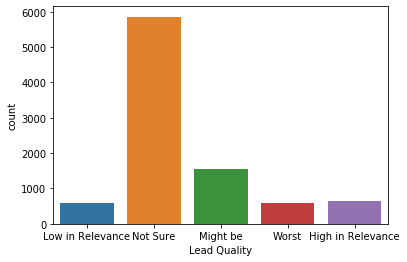

In [22]:
# Impute 'Not Sure' for null values
df_leads['Lead Quality'] = df_leads['Lead Quality'].replace(np.nan, 'Not Sure')
# Verify the distribution of column values after imputing null values
sns.countplot(df_leads['Lead Quality'])

City column has next higher percentage of null values which is 39%.

Lets look at data to find out most of the Leads coming from which city.

In [23]:
df_leads['City'].value_counts()

Mumbai                         3222
Thane & Outskirts              752 
Other Cities                   686 
Other Cities of Maharashtra    457 
Other Metro Cities             380 
Tier II Cities                 74  
Name: City, dtype: int64

when we calculate the percentage, the 58% leads belongs to Mumbai. Hence, we have decided to impute "Mumbai" as city for missing values. 

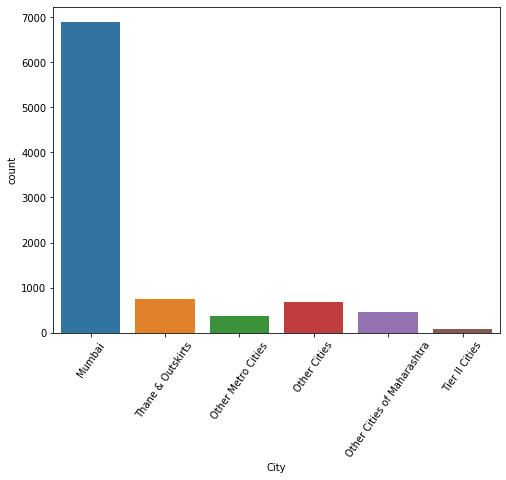

In [24]:
# Impute 'Mumbai' for null values using Mode
df_leads['City'] = df_leads['City'].fillna(df_leads['City'].mode()[0])
# Verify the distribution of City column values after imputing null values
plt.figure(figsize = (8,6)) 
sns.countplot(df_leads['City'])
plt.tick_params(axis ='x', rotation = 55)

The next column with higher percentage of null values is "Specialization" which is having 36.58% null values.

The blank values in "Specialization" columns might exists because the lead doesn't have any specialization. Or the drop-down list doesn't contain a value with matching specialization for the lead who is filling the form. We have decided to create a new category as "Others" for handling both the scenarios.

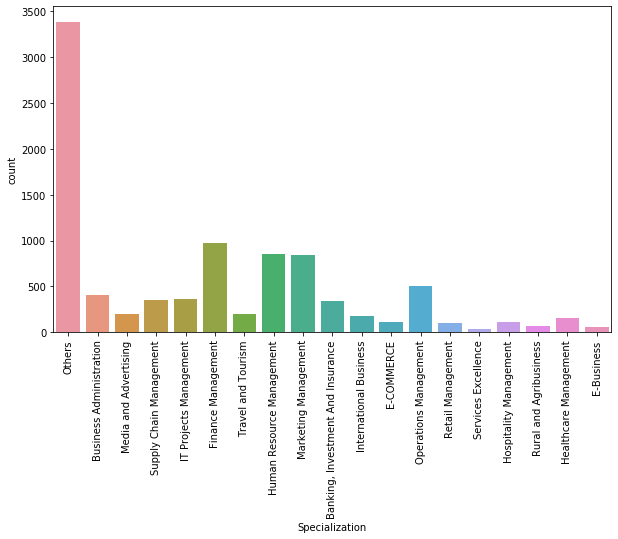

In [25]:
# Impute 'Others' for null values in Specialization field
df_leads['Specialization'] = df_leads['Specialization'].replace(np.nan, 'Others')
# Verify the distribution of column values after imputing null values
plt.figure(figsize = (10,6)) 
sns.countplot(df_leads['Specialization'])
plt.tick_params(axis ='x', rotation = 90)

We have then analyzed the Tags columns which has 36.29% missing values.

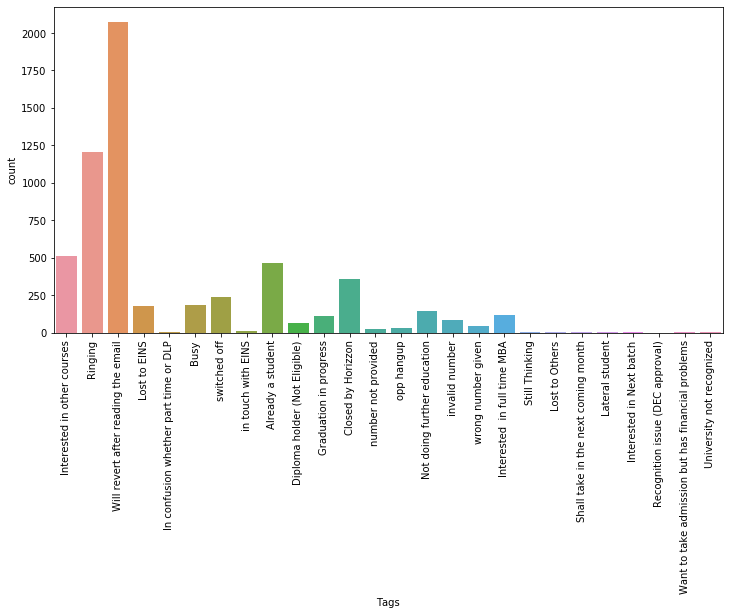

In [26]:
plt.figure(figsize = (12,6)) 
sns.countplot(df_leads['Tags'])
plt.tick_params(axis ='x', rotation = 90)

In [27]:
df_leads['Tags'].describe()

count     5887                               
unique    26                                 
top       Will revert after reading the email
freq      2072                               
Name: Tags, dtype: object

As per the above bar plot and describe method results, we have decided to replace the null values for Tags using top value of "Will revert after reading the email".

In [28]:
# Impute "Will revert after reading the email" for null values using Mode
df_leads['Tags'] = df_leads['Tags'].fillna(df_leads['Tags'].mode()[0])

In similar way, we have decided to analyse and fix below two columns which has approximately 29% missing data.
- What is your current occupation
- What matters most to you in choosing a course

In [29]:
df_leads[['What is your current occupation','What matters most to you in choosing a course']].describe()

,What is your current occupation,What matters most to you in choosing a course
count,6550,6531
unique,6,3
top,Unemployed,Better Career Prospects
freq,5600,6528


In [30]:
# Impute null values using Mode
df_leads['What is your current occupation'] = df_leads['What is your current occupation'].fillna(df_leads['What is your current occupation'].mode()[0])
df_leads['What matters most to you in choosing a course'] = df_leads['What matters most to you in choosing a course'].fillna(df_leads['What matters most to you in choosing a course'].mode()[0])

Finally, the last column with higher number of null values is Country which contains 26.63% missing values.

Lets analyze the data for this column.

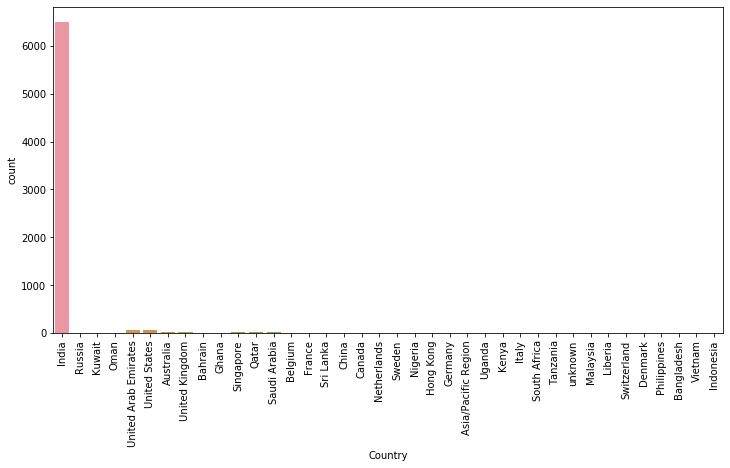

In [31]:
plt.figure(figsize = (12,6)) 
sns.countplot(df_leads['Country'])
plt.tick_params(axis ='x', rotation = 90)

As we can see, majority of Leads are from India, we have decided to impute the null values for Country using "India"

In [32]:
# Impute "India" for null values in Country using Mode
df_leads['Country'] = df_leads['Country'].fillna(df_leads['Country'].mode()[0])

Now, look at the null values percentage for each column again.

In [33]:
round(100*(df_leads.isnull().sum()/len(df_leads.index)), 2)

Prospect ID                                     0.00
Lead Number                                     0.00
Lead Origin                                     0.00
Lead Source                                     0.39
Do Not Email                                    0.00
Do Not Call                                     0.00
Converted                                       0.00
TotalVisits                                     1.48
Total Time Spent on Website                     0.00
Page Views Per Visit                            1.48
Last Activity                                   1.11
Country                                         0.00
Specialization                                  0.00
What is your current occupation                 0.00
What matters most to you in choosing a course   0.00
Search                                          0.00
Magazine                                        0.00
Newspaper Article                               0.00
X Education Forums                            

As we can see there are very less percent (<2%) of null values for remaining columns, we have decided to drop those rows with null values. 

In [34]:
df_leads.dropna(inplace = True)
# Verify the dataframe now to ensure it has 0% missing values
round(100*(df_leads.isnull().sum()/len(df_leads.index)), 2)

Prospect ID                                     0.00
Lead Number                                     0.00
Lead Origin                                     0.00
Lead Source                                     0.00
Do Not Email                                    0.00
Do Not Call                                     0.00
Converted                                       0.00
TotalVisits                                     0.00
Total Time Spent on Website                     0.00
Page Views Per Visit                            0.00
Last Activity                                   0.00
Country                                         0.00
Specialization                                  0.00
What is your current occupation                 0.00
What matters most to you in choosing a course   0.00
Search                                          0.00
Magazine                                        0.00
Newspaper Article                               0.00
X Education Forums                            

#### Check the final shape of the dataframe after completion of the data cleaning process

In [35]:
df_leads.shape

(9074, 31)

#### 2.3 Handle columns with unique values (which doesn't implact our prediction model) 

Prospect Id and Lead Number columns contains unique values for each row in the dataframe. These columns will not contribute to our prediction model. Hence, we have decided to remove these columns.

In [36]:
df_leads.drop(['Prospect ID','Lead Number'], axis=1,inplace=True)
# Check the shape after dropping these 2 columns
df_leads.shape

(9074, 29)

#### 2.4 Drop columns with single value (which doesn't implact our prediction model) 

Based on our initial analysis of leads dataset, we have observed few categorial columns contains only single value such as "No" for binary value columns. These columns will not have any impact of our model prediction capability, hence, we have decided to drop these columns.

In [37]:
col_list = get_categorial_columns(df_leads)
#Drop column with single value
for col_name in col_list:
    if df_leads[col_name].nunique() == 1:        
        df_leads.drop([col_name], axis=1, inplace=True)
        print("Dropped Column : {}".format(col_name))

Dropped Column : Magazine
Dropped Column : Receive More Updates About Our Courses
Dropped Column : Update me on Supply Chain Content
Dropped Column : Get updates on DM Content
Dropped Column : I agree to pay the amount through cheque


#### 2.5 Drop columns with high imbalance i.e. column values with very less variance 

During our analysis of leads data, we also noticed few categorial columns has 

In [38]:
col_list = get_categorial_columns(df_leads)
for col_name in col_list:
    print("Column value frquency for : {}".format(col_name))
    print("-----------------------------------------------------------------------")
    print(df_leads[col_name].value_counts())
    print("-----------------------------------------------------------------------")

Column value frquency for : Lead Origin
-----------------------------------------------------------------------
Landing Page Submission    4885
API                        3578
Lead Add Form              581 
Lead Import                30  
Name: Lead Origin, dtype: int64
-----------------------------------------------------------------------
Column value frquency for : Lead Source
-----------------------------------------------------------------------
Google               2868
Direct Traffic       2543
Olark Chat           1753
Organic Search       1154
Reference            443 
Welingak Website     129 
Referral Sites       125 
Facebook             31  
bing                 6   
google               5   
Click2call           4   
Social Media         2   
Press_Release        2   
Live Chat            2   
welearnblog_Home     1   
youtubechannel       1   
Pay per Click Ads    1   
blog                 1   
testone              1   
NC_EDM               1   
WeLearn              1  

In [39]:
# Drop the columns with very low variance in the categories
col_list = ['Do Not Call', 'What matters most to you in choosing a course', 'Search', 
            'Newspaper Article', 'X Education Forums', 'Newspaper',
            'Digital Advertisement', 'Through Recommendations', 'Country']
for col_name in col_list:
    df_leads.drop([col_name], axis=1, inplace=True)
    print("Dropped Column : {}".format(col_name))

Dropped Column : Do Not Call
Dropped Column : What matters most to you in choosing a course
Dropped Column : Search
Dropped Column : Newspaper Article
Dropped Column : X Education Forums
Dropped Column : Newspaper
Dropped Column : Digital Advertisement
Dropped Column : Through Recommendations
Dropped Column : Country


### Step 3: Outlier Analysis

In [40]:
df_leads.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9074.00,9074.00,9074.00,9074.00
mean,0.38,3.46,482.89,2.37
std,0.49,4.86,545.26,2.16
min,0.00,0.00,0.00,0.00
25%,0.00,1.00,11.00,1.00
50%,0.00,3.00,246.00,2.00
75%,1.00,5.00,922.75,3.20
90%,1.00,7.00,1373.00,5.00
95%,1.00,10.00,1557.00,6.00
99%,1.00,17.00,1839.00,9.00


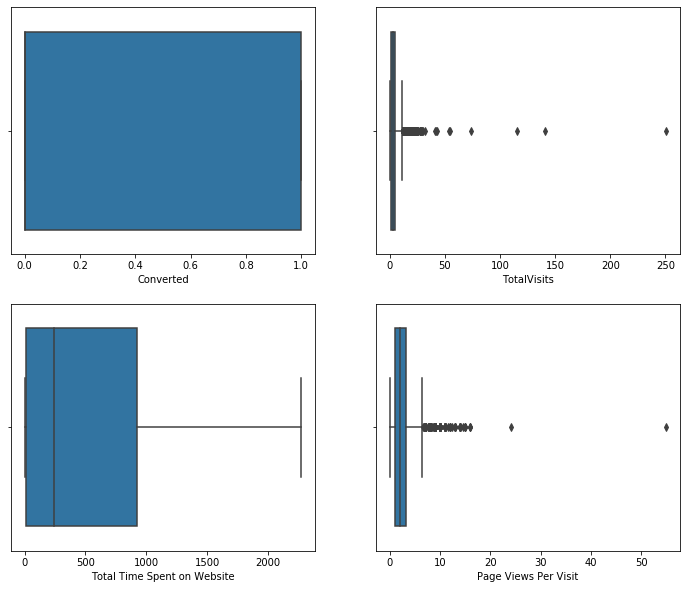

In [41]:
# Check outliers
plt.figure(figsize = (12,10))
col_list = ['Converted','TotalVisits','Total Time Spent on Website','Page Views Per Visit']
for i in enumerate(col_list):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(x = i[1], data = df_leads)

#### <u>Analysis Summary</u>:
1. "Converted" column is having only two values - either 0 or 1, so there are no outliers to be addressed.
2. "Total Time Spent on Website" column data also doesn't contain any outliers.
3. "TotalVisits" and "Page Views Per Visit" columns has large number of outliers which needs to be treated.
4. Looking at percentile values we have decided to cap the outliers for these two columns between 5% to 95% value for analysis.

In [42]:
# Cap outliers for "TotalVisits" and "Page Views Per Visit" columns
percentiles = df_leads['TotalVisits'].quantile([0.05,0.95]).values
df_leads['TotalVisits'][df_leads['TotalVisits'] <= percentiles[0]] = percentiles[0]
df_leads['TotalVisits'][df_leads['TotalVisits'] >= percentiles[1]] = percentiles[1]
percentiles = df_leads['Page Views Per Visit'].quantile([0.05,0.95]).values
df_leads['Page Views Per Visit'][df_leads['Page Views Per Visit'] <= percentiles[0]] = percentiles[0]
df_leads['Page Views Per Visit'][df_leads['Page Views Per Visit'] >= percentiles[1]] = percentiles[1]

Verify the box plots for "TotalVisits" and "Page Views Per Visit" columns after removing outliers

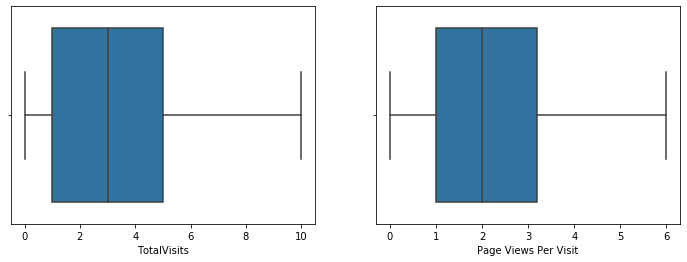

In [43]:
# Verification post removing the outliers 
plt.figure(figsize = (12,4))
col_list = ['TotalVisits','Page Views Per Visit']
for i in enumerate(col_list):
    plt.subplot(1,2,i[0]+1)
    sns.boxplot(x = i[1], data = df_leads)

### Step 3: Univariate Analysis

#### Analysis of "Converted" column (Class label)

In [44]:
## Categorical Columns
100*(df_leads['Converted'].value_counts()/ df_leads.shape[0])

0   62.14
1   37.86
Name: Converted, dtype: float64

#### The dataset imbalance ratio is of 62 : 38, which indicates dataset <u>is not highly imbalanced</u>.

This can also seen visually by below bar chart.

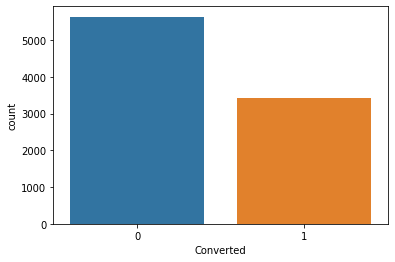

In [45]:
sns.countplot(x = 'Converted', data=df_leads)

#### Analysis of "Lead Origin" column

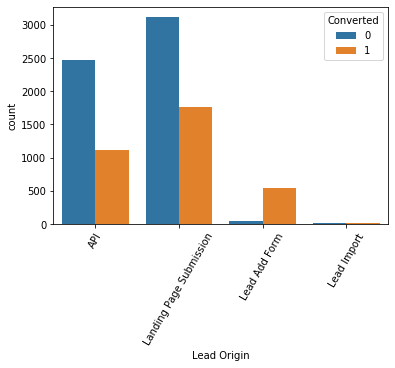

In [46]:
sns.countplot(x = "Lead Origin", hue = "Converted", data = df_leads)
plt.tick_params(axis ='x', rotation = 60)

#### <u>Analysis Summary</u>:
1. Highest number of leads originated from Landing Page Submission followed by API. However, the conversion rate for these leads is less than ~50% as seen from above bar plot.
2. Though, number of leads originated from Lead Add Form are lower, leads conversion rate is very high around 90%.
3. Lead Import is having lowest number of leads originated and hence leads converted as well.

##### This indicates that to improve total lead conversion rate, X Education need to focus more on improving lead converion of API and Landing Page sources. Since, the Lead Add Form has the highest number of lead conversion, more leads should be generated using Lead Add Form, which will also help to improve overall lead conversion ratio.

#### Analysis of "Lead Source" column

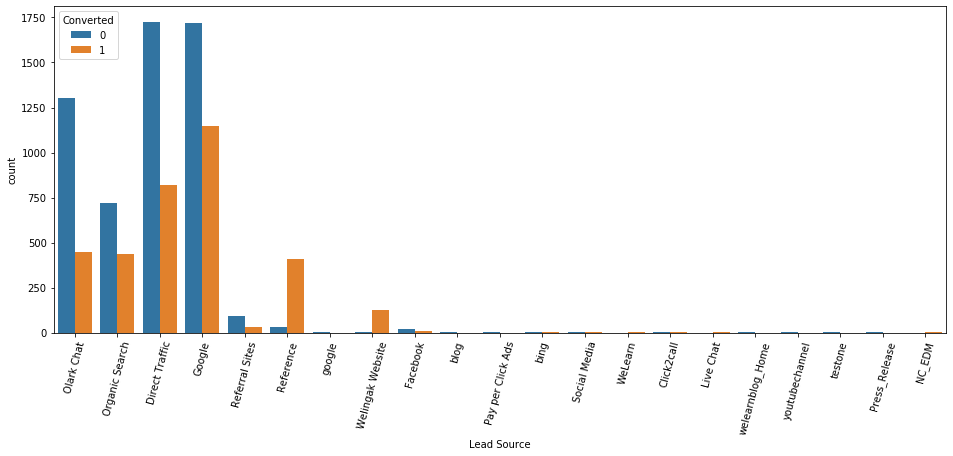

In [47]:
plt.figure(figsize = (16,6)) 
sns.countplot(x = "Lead Source", hue = "Converted", data = df_leads)
plt.tick_params(axis ='x', rotation = 75)

#### <u>Analysis Summary</u>:
1. Highest number of leads sourced from Direct Traffic and Google, followed by Olark Chat and Organic Search.
2. Though, number of leads sourced from Reference and Welingak Website are lower, leads conversion rate is very high for these sources.

##### This indicates that to improve total lead conversion rate, X Education need to focus more on improving lead converion of Direct Traffic, Google, Olark Chat and Organic Search. Since, the Reference and Welingak Website has the highest number of lead conversion, more leads should be generated using Reference and Welingak Website, which will also help to improve overall lead conversion ratio.

#### Analysis of "Lead Origin" column

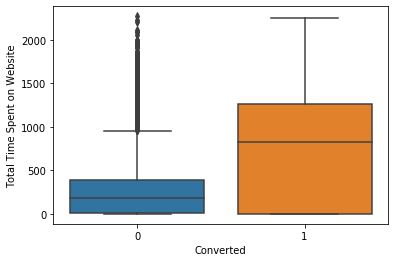

In [48]:
sns.boxplot(x = 'Converted', y = 'Total Time Spent on Website', data = df_leads)

#### <u>Analysis Summary</u>:
Based on the analysis of the above box plot for "Total Time Spent on Website", we can conclude that lead who spend more time on the website has better potential of conversion. 

X Education need to focus on making the web site more intuitive and engaging, so that leads can spend more time going through the web site contents and know about online courses. This will result in increases conversion ratio.

#### Analysis of current Occupation column

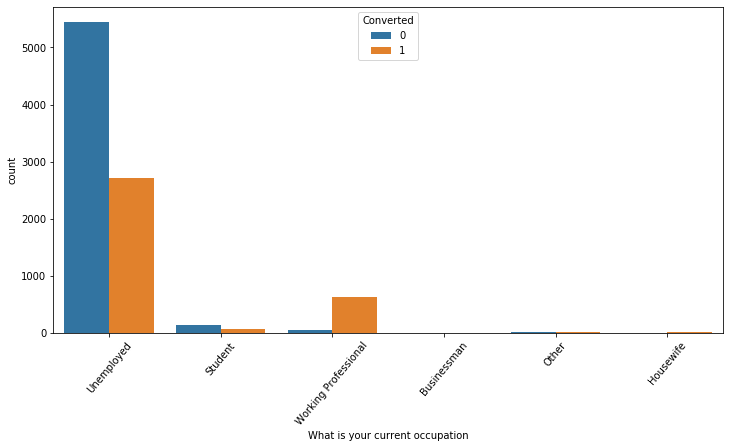

In [49]:
plt.figure(figsize = (12,6)) 
sns.countplot(x = "What is your current occupation", hue = "Converted", data = df_leads)
plt.tick_params(axis ='x', rotation = 50)

#### <u>Analysis Summary</u>:
Though, the highest rate of leads are unemployed, the conversion rate for working professional is highest.   

## Section 2: Data Preparation

### Step 1 :  Converting binary variables (Yes/No) to 0/1

 Lets look at the dataframe to find out the columns with binary (Yes/ No) values

In [50]:
df_leads.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,Lead Quality,City,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,0,0.00,0,0.00,Page Visited on Website,Others,Unemployed,Interested in other courses,Low in Relevance,Mumbai,No,Modified
1,API,Organic Search,No,0,5.00,674,2.50,Email Opened,Others,Unemployed,Ringing,Not Sure,Mumbai,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,1,2.00,1532,2.00,Email Opened,Business Administration,Student,Will revert after reading the email,Might be,Mumbai,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,0,1.00,305,1.00,Unreachable,Media and Advertising,Unemployed,Ringing,Not Sure,Mumbai,No,Modified
4,Landing Page Submission,Google,No,1,2.00,1428,1.00,Converted to Lead,Others,Unemployed,Will revert after reading the email,Might be,Mumbai,No,Modified


In [51]:
col_list = ['Do Not Email', 'A free copy of Mastering The Interview']
# Applying the binary_map function to the bianary columns
df_leads[col_list] = df_leads[col_list].apply(binary_map)
# Validate the data set
df_leads.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,Lead Quality,City,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,0,0,0.00,0,0.00,Page Visited on Website,Others,Unemployed,Interested in other courses,Low in Relevance,Mumbai,0,Modified
1,API,Organic Search,0,0,5.00,674,2.50,Email Opened,Others,Unemployed,Ringing,Not Sure,Mumbai,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,1,2.00,1532,2.00,Email Opened,Business Administration,Student,Will revert after reading the email,Might be,Mumbai,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,1.00,305,1.00,Unreachable,Media and Advertising,Unemployed,Ringing,Not Sure,Mumbai,0,Modified
4,Landing Page Submission,Google,0,1,2.00,1428,1.00,Converted to Lead,Others,Unemployed,Will revert after reading the email,Might be,Mumbai,0,Modified


### Step 2 :  One-hot encoding for categorical variables with multiple levels

Creating a dummy variable for categorical variables with multiple levels and dropping the first one.

In [52]:
col_list = ['Lead Origin', 'Lead Source', 'Last Activity', 
            'Specialization','What is your current occupation',
            'Tags','Lead Quality','City','Last Notable Activity']
dummy1 = pd.get_dummies(df_leads[col_list], drop_first=True)

Adding the results to the leads dataframe

In [53]:
df_leads = pd.concat([df_leads, dummy1], axis=1)

Drop the original columns which no more needed

In [54]:
df_leads = df_leads.drop(col_list, axis = 1)

Verify the leads dataset after one-hot encoding

In [55]:
df_leads.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_google,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,5.00,674,2.50,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

Check the shape of the final dataframe

In [56]:
df_leads.shape

(9074, 117)

### Step 3 : Train-Test Split

Since, we have already taken care of null values and outliers in the dataset, we can now proceed with the splitting the dataset in train and test datasets.

Putting feature (predictor) variables to X

In [57]:
X = df_leads.drop(['Converted'], axis=1)

Putting response (class) variable to y

In [58]:
y = df_leads['Converted']

Splitting the data into train and test

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Step 4: Feature Scaling

Get the list of columns which needs standardized scaling

In [60]:
col_list = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']

Apply Standard Scaler  

In [61]:
scaler = StandardScaler()
X_train[col_list] = scaler.fit_transform(X_train[col_list])
X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_google,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
3009,0,-0.43,-0.16,-0.16,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1012,1,-0.43,-0.54,-0.16,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

## Section 3: Model Training

### Step 1: Train the first instance of the Logistic Regression Model

In [62]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6237
Model Family:                Binomial   Df Model:                          113
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1235.1
Date:                Mon, 02 Mar 2020   Deviance:                       2470.2
Time:                        18:28:56   Pearson chi2:                 3.74e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                     27.8150   2.08e+05      0.000      1.000   -4.09e+05    4.09e+05
Do Not Email                                              -1.3933      0.338     -4.121      0.000      -2.056      -0.731
TotalVisits                                                0.1937      0.088      2.209      0.027       0.022       0.366
Total Time Spent on Website                                1.1482      0.064     17.880      0.000       1.022       1.274
Page Views Per Visit                                      -0.3272      0.100     -3.283      0.001      -0.523      -0.132
A free copy of Mastering The Interview                    -0.2526      0.179     -1.414      0.157      -0.603       0.098
Lead Origin_Landing Page Submission                       -0.9571      0.225     -4.257      0.000      -1.398      -0.516
Lead Origin_Lead Add Form                                 -2.9098      3.461     -0.841      0.400      -9.693       3.873
Lead Origin_Lead Import                                   29.5950   2.12e+05      0.000      1.000   -4.16e+05    4.16e+05
Lead Source_Direct Traffic                                -3.4160      4.146     -0.824      0.410     -11.543       4.711
Lead Source_Facebook                                     -32.0357   2.12e+05     -0.000      1.000   -4.16e+05    4.16e+05
Lead Source_Google                                        -3.3484      4.145     -0.808      0.419     -11.472       4.775
Lead Source_Live Chat                                     23.7730   1.37e+05      0.000      1.000   -2.68e+05    2.68e+05
Lead Source_NC_EDM                                        22.2792    2.1e+05      0.000      1.000   -4.12e+05    4.12e+05
Lead Source_Olark Chat                                    -2.6057      4.137     -0.630      0.529     -10.714       5.503
Lead Source_Organic Search                                -3.2778      4.148     -0.790      0.429     -11.407       4.852
Lead Source_Pay per Click Ads                            -21.4178   2.16e+05  -9.93e-05      1.000   -4.23e+05    4.23e+05
Lead Source_Press_Release                                -26.0929   2.14e+05     -0.000      1.000    -4.2e+05     4.2e+05
Lead Source_Reference                                      0.8548      2.292      0.373      0.709      -3.637       5.347
Lead Source_Referral Sites                                -3.6022      4.172     -0.863      0.388     -11.779       4.574
Lead Source_Social Media                                  -0.1199      7.999     -0.015      0.988     -15.798      15.559
Lead Source_WeLearn                                     3.346e-09   3.86e-05   8.67e-05      1.000   -7.57e-05    7.57e-05
Lead Sou

### Step 2: Feature Selection Using RFE

In [63]:
logreg_model = LogisticRegression()

In [64]:
# Running RFE with 15 variables as output
rfe = RFE(logreg_model, 15)
rfe = rfe.fit(X_train, y_train)

In [65]:
rfe.support_

array([ True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False,  True, False,  True,  True, False,
        True, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False])

In [66]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('TotalVisits', False, 55),
 ('Total Time Spent on Website', False, 4),
 ('Page Views Per Visit', False, 53),
 ('A free copy of Mastering The Interview', False, 49),
 ('Lead Origin_Landing Page Submission', False, 20),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 3),
 ('Lead Source_Direct Traffic', False, 68),
 ('Lead Source_Facebook', False, 52),
 ('Lead Source_Google', False, 74),
 ('Lead Source_Live Chat', False, 70),
 ('Lead Source_NC_EDM', False, 25),
 ('Lead Source_Olark Chat', False, 6),
 ('Lead Source_Organic Search', False, 76),
 ('Lead Source_Pay per Click Ads', False, 101),
 ('Lead Source_Press_Release', False, 83),
 ('Lead Source_Reference', False, 75),
 ('Lead Source_Referral Sites', False, 54),
 ('Lead Source_Social Media', False, 59),
 ('Lead Source_WeLearn', False, 102),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 51),
 ('Lead Source_blog', False, 48),
 ('Lead Source_google', False

In [67]:
col_list = X_train.columns[rfe.support_]
col_list

Index(['Do Not Email', 'Lead Origin_Lead Add Form',
       'Lead Source_Welingak Website',
       'What is your current occupation_Working Professional', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_number not provided', 'Tags_switched off',
       'Lead Quality_Not Sure', 'Lead Quality_Worst',
       'Last Notable Activity_SMS Sent'],
      dtype='object')

In [68]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Source_Direct Traffic', 'Lead Source_Facebook',
       'Lead Source_Google', 'Lead Source_Live Chat',
       ...
       'Last Notable Activity_Email Received',
       'Last Notable Activity_Form Submitted on Website',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_Page Visited on Website',
       'Last Notable Activity_Resubscribed to emails',
       'Last Notable Activity_Unreachable',
       'Last Notable Activity_Unsubscribed',
       'Last Notable Activity_View in browser link Clicked'],
      dtype='object', length=101)

##### Assessing the model with StatsModels (2nd instance of LR model)

In [69]:
X_train_sm = sm.add_constant(X_train[col_list])
logreg_model_2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logreg_model_2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1579.7
Date:                Mon, 02 Mar 2020   Deviance:                       3159.4
Time:                        18:29:04   Pearson chi2:                 3.13e+04
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.8388      0.213     -8.638      0.000      -2.256      -1.422
Do Not Email                                            -1.2901      0.214     -6.040      0.000      -1.709      -0.871
Lead Origin_Lead Add Form                                1.0391      0.361      2.882      0.004       0.332       1.746
Lead Source_Welingak Website                             3.4683      0.817      4.244      0.000       1.867       5.070
What is your current occupation_Working Professional     1.2770      0.287      4.452      0.000       0.715       1.839
Tags_Busy                                                3.5326      0.331     10.674      0.000       2.884       4.181
Tags_Closed by Horizzon                                  7.7308      0.762     10.152      0.000       6.238       9.223
Tags_Lost to EINS                                        8.9495      0.753     11.889      0.000       7.474      10.425
Tags_Ringing                                            -1.9939      0.339     -5.883      0.000      -2.658      -1.330
Tags_Will revert after reading the email                 3.7217      0.226     16.449      0.000       3.278       4.165
Tags_invalid number                                    -22.4878   1.34e+04     -0.002      0.999   -2.63e+04    2.63e+04
Tags_number not provided                               -22.9675   2.33e+04     -0.001      0.999   -4.57e+04    4.57e+04
Tags_switched off                                       -2.5983      0.588     -4.415      0.000      -3.752      -1.445
Lead Quality_Not Sure                                   -3.3581      0.129    -26.079      0.000      -3.610      -3.106
Lead Quality_Worst                                      -3.8185      0.843     -4.530      0.000      -5.471      -2.166
Last Notable Activity_SMS Sent                           2.8042      0.123     22.864      0.000       2.564       3.045
========================================================================================================================
"""

### Step 3: Manual Features Selection Using p-Value and VIF

As observed from above StatsModel summary output, <b><i>Tags_invalid number</i></b> feature has highest p-Value of 0.99 which is greater than  significance value of 0.05. Hence, we have decided to remove this column.

In [70]:
col_list = col_list.drop('Tags_invalid number',1)

##### Retrian the model with StatsModels API (3rd instance of LR model)

In [71]:
X_train_sm = sm.add_constant(X_train[col_list])
logreg_model_3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logreg_model_3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1585.8
Date:                Mon, 02 Mar 2020   Deviance:                       3171.6
Time:                        18:29:04   Pearson chi2:                 3.08e+04
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.0029      0.215     -9.300      0.000      -2.425      -1.581
Do Not Email                                            -1.2838      0.213     -6.028      0.000      -1.701      -0.866
Lead Origin_Lead Add Form                                1.0711      0.362      2.957      0.003       0.361       1.781
Lead Source_Welingak Website                             3.4313      0.818      4.197      0.000       1.829       5.034
What is your current occupation_Working Professional     1.3170      0.290      4.545      0.000       0.749       1.885
Tags_Busy                                                3.7141      0.330     11.256      0.000       3.067       4.361
Tags_Closed by Horizzon                                  7.8819      0.762     10.342      0.000       6.388       9.376
Tags_Lost to EINS                                        9.1061      0.754     12.085      0.000       7.629      10.583
Tags_Ringing                                            -1.7954      0.337     -5.322      0.000      -2.457      -1.134
Tags_Will revert after reading the email                 3.8844      0.228     17.038      0.000       3.438       4.331
Tags_number not provided                               -21.7668   1.42e+04     -0.002      0.999   -2.78e+04    2.78e+04
Tags_switched off                                       -2.3933      0.587     -4.074      0.000      -3.545      -1.242
Lead Quality_Not Sure                                   -3.3493      0.129    -26.060      0.000      -3.601      -3.097
Lead Quality_Worst                                      -3.8282      0.843     -4.539      0.000      -5.481      -2.175
Last Notable Activity_SMS Sent                           2.7603      0.121     22.863      0.000       2.524       2.997
========================================================================================================================
"""

Dropping the column <b><i>Tags_number not provided</i></b> feature with highest p-Value of 0.99, which is greater than  significance value of 0.05. 

In [72]:
col_list = col_list.drop('Tags_number not provided',1)

##### Retrian the model with StatsModels API (4th instance of LR model)

In [73]:
X_train_sm = sm.add_constant(X_train[col_list])
logreg_model_4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logreg_model_4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1588.8
Date:                Mon, 02 Mar 2020   Deviance:                       3177.6
Time:                        18:29:04   Pearson chi2:                 3.08e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.0888      0.216     -9.654      0.000      -2.513      -1.665
Do Not Email                                            -1.3012      0.212     -6.134      0.000      -1.717      -0.885
Lead Origin_Lead Add Form                                1.0894      0.363      3.001      0.003       0.378       1.801
Lead Source_Welingak Website                             3.4138      0.818      4.173      0.000       1.810       5.017
What is your current occupation_Working Professional     1.3403      0.291      4.602      0.000       0.769       1.911
Tags_Busy                                                3.8040      0.330     11.532      0.000       3.157       4.450
Tags_Closed by Horizzon                                  7.9562      0.763     10.433      0.000       6.461       9.451
Tags_Lost to EINS                                        9.1785      0.754     12.177      0.000       7.701      10.656
Tags_Ringing                                            -1.6947      0.337     -5.036      0.000      -2.354      -1.035
Tags_Will revert after reading the email                 3.9665      0.229     17.311      0.000       3.517       4.416
Tags_switched off                                       -2.2882      0.587     -3.900      0.000      -3.438      -1.138
Lead Quality_Not Sure                                   -3.3406      0.128    -26.026      0.000      -3.592      -3.089
Lead Quality_Worst                                      -3.7624      0.850     -4.426      0.000      -5.428      -2.096
Last Notable Activity_SMS Sent                           2.7406      0.120     22.847      0.000       2.506       2.976
========================================================================================================================
"""

#### <u>Analysis Summary</u>:
Based on Summary statistics, all the feature has less p-Value than 0.05, which means <b>all the features are significant</b>.

Next, we will check for the VIF scores of features.

In [74]:
check_vif(X_train_sm)

,Features,VIF
0,const,12.69
9,Tags_Will revert after reading the email,2.48
8,Tags_Ringing,1.84
12,Lead Quality_Worst,1.67
11,Lead Quality_Not Sure,1.53
2,Lead Origin_Lead Add Form,1.52
6,Tags_Closed by Horizzon,1.39
3,Lead Source_Welingak Website,1.35
4,What is your current occupation_Working Professional,1.22
10,Tags_switched off,1.19


#### <u>Analysis Summary</u>:
VIF table shows that all features has VIF value f less than 2.5 indicating there is <b>no multicollinearity issue</b>.

Hence, we have considered this as a final trained model.

## Section 4: Model Validation

### Step 1: Final trained model validation

#### Getting the predicted values on the train set

In [75]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

3009   0.19
1012   0.19
9226   0.00
4750   0.78
7987   0.98
1281   0.99
2880   0.19
4971   0.75
7536   0.87
1248   0.00
dtype: float64

In [76]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([1.88037158e-01, 1.94070077e-01, 8.04879357e-04, 7.82076694e-01,
       9.77003470e-01, 9.90227993e-01, 1.88037158e-01, 7.53103755e-01,
       8.67356930e-01, 8.04879357e-04])

#### Creating a dataframe with "Converted" column and "Convert_Probability"  

In [77]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Convert_Probability':y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

,Converted,Convert_Probability,Prospect ID
0,0,0.19,3009
1,0,0.19,1012
2,0,0.00,9226
3,1,0.78,4750
4,1,0.98,7987


####  Adding new column "Intial_Prection" with value 1 if Convert_Probability > 0.5 (i.e more than 50% probability of conversion), otherwise Convert_Probability = 0

In [78]:
y_train_pred_final['Predicted'] = y_train_pred_final.Convert_Probability.map(lambda x: 1 if x > 0.5 else 0)

In [79]:
# Check the dataframe 
y_train_pred_final.head()

,Converted,Convert_Probability,Prospect ID,Predicted
0,0,0.19,3009,0
1,0,0.19,1012,0
2,0,0.00,9226,0
3,1,0.78,4750,1
4,1,0.98,7987,1


####  Checking the overall accuracy score

In [80]:
print(round(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted),2))

0.92


#### Lets analyze the Confusion matrix  

In [81]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted)
print(confusion)

[[3756  149]
 [ 363 2083]]


### Step 2: Checking Metrics beyond simple accuracy

In [82]:
tn, fp, fn, tp = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted).ravel()

#### Lets look at the Sensitivity and Specificity of our final Logistic Regression Model.

In [83]:
print("Sensitivity of our final model : {}".format(round(tp / float(tp+fn),2)))

Sensitivity of our final model : 0.85


In [84]:
print("Specificity of our final model : {}".format(round(tn / float(tn+fp),2)))

Specificity of our final model : 0.96


#### Calculate false postive rate (i.e. predicting converted when lead is actually not converted), positive predictive value and negative predictive value of our final trained model.

In [85]:
print("False positive rate for our model : {}".format(round(fp/ float(tn+fp),2)))

False positive rate for our model : 0.04


In [86]:
print("Positive predictive value for our model : {}".format(round(tp / float(tp+fp),2)))

Positive predictive value for our model : 0.93


In [87]:
print("Negative predictive value for our model : {}".format(round(tn / float(tn+ fn),2)))

Negative predictive value for our model : 0.91


### Step 3: Plotting the ROC Curve

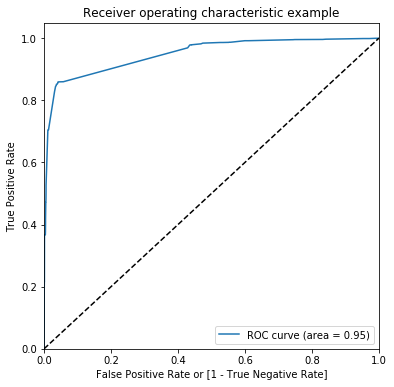

In [88]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Converted, \
                                         y_train_pred_final.Convert_Probability, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Convert_Probability)

#### <u>Analysis Summary</u>:
An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

#### As seen above we are getting ideal ROC curve for our final model.

### Step 4: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [89]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Convert_Probability.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Convert_Probability,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.19,3009,0,1,1,0,0,0,0,0,0,0,0
1,0,0.19,1012,0,1,1,0,0,0,0,0,0,0,0
2,0,0.00,9226,0,1,0,0,0,0,0,0,0,0,0
3,1,0.78,4750,1,1,1,1,1,1,1,1,1,0,0
4,1,0.98,7987,1,1,1,1,1,1,1,1,1,1,1


In [90]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy  sensi  speci
0.00 0.00  0.39      1.00   0.00  
0.10 0.10  0.71      0.98   0.53  
0.20 0.20  0.91      0.86   0.94  
0.30 0.30  0.92      0.86   0.96  
0.40 0.40  0.92      0.86   0.96  
0.50 0.50  0.92      0.85   0.96  
0.60 0.60  0.92      0.85   0.96  
0.70 0.70  0.92      0.85   0.97  
0.80 0.80  0.88      0.71   0.99  
0.90 0.90  0.81      0.52   0.99  


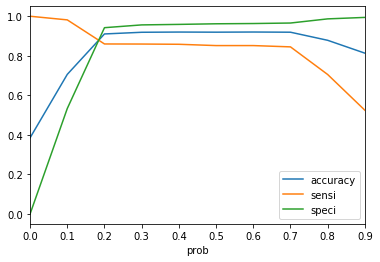

In [91]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### <u>Analysis Summary</u>:
Based on the curve above, the optimum point is 0.2 to be consider as a cutoff probability.

In [92]:
y_train_pred_final['Final_Predicted'] = y_train_pred_final.Convert_Probability.map( lambda x: 1 if x > 0.2 else 0)
y_train_pred_final.head()

,Converted,Convert_Probability,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Final_Predicted
0,0,0.19,3009,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.19,1012,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0.00,9226,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.78,4750,1,1,1,1,1,1,1,1,1,0,0,1
4,1,0.98,7987,1,1,1,1,1,1,1,1,1,1,1,1


### Step 5: Model evaluation with Final_Predicted  column

####  Checking the overall accuracy score for final trained model

In [93]:
print(round(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted),2))

0.91


In [94]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted)
print(confusion)

[[3679  226]
 [ 343 2103]]


In [95]:
tn, fp, fn, tp = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted).ravel()

#### Lets look at the Sensitivity and Specificity of our final Logistic Regression Model.

In [96]:
print("Sensitivity of our final model : {}".format(round(tp / float(tp+fn),2)))

Sensitivity of our final model : 0.86


In [97]:
print("Specificity of our final model : {}".format(round(tn / float(tn+fp),2)))

Specificity of our final model : 0.94


#### Calculate false postive rate (i.e. predicting converted when lead is actually not converted), positive predictive value and negative predictive value of our final trained model.

In [98]:
print("False positive rate for our model : {}".format(round(fp/ float(tn+fp),2)))

False positive rate for our model : 0.06


In [99]:
print("Positive predictive value for our model : {}".format(round(tp / float(tp+fp),2)))

Positive predictive value for our model : 0.9


In [100]:
print("Negative predictive value for our model : {}".format(round(tn / float(tn+ fn),2)))

Negative predictive value for our model : 0.91


### Step 5: Precision and Recall Analysis

Get the Precision score

In [101]:
precision = round(precision_score(y_train_pred_final.Converted , y_train_pred_final.Final_Predicted),2)

Get the Recall score

In [102]:
recall = round(recall_score(y_train_pred_final.Converted, y_train_pred_final.Final_Predicted),2)

Calculate the F1 Score

In [103]:
2*(precision*recall)/(precision+recall)

0.8795454545454545

#### Precision and Recall trade-off

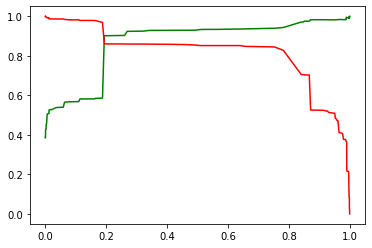

In [104]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Convert_Probability)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")

#### <u>Analysis Summary</u>:
Based on the above precision recall curve, the convergence is between 1.8 and 0.2. As per the Precision and Recall trade-off, our cut off 2.0 proved as correct selection.  

## Section 5: Making predictions on the test set

### Step 1: Feature Scaling (for Test dataset)

In [105]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_test.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Pay per Click Ads,Lead Source_Press_Release,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_WeLearn,Lead Source_Welingak Website,Lead Source_bing,Lead Source_blog,Lead Source_google,Lead Source_testone,Lead Source_welearnblog_Home,Lead Source_youtubechannel,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Marked Spam,Last Activity_Email Opened,Last Activity_Email Received,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_In confusion whether part time or DLP,Tags_Interested in full time MBA,Tags_Interested in Next batch,Tags_Interested in other courses,Tags_Lateral student,Tags_Lost to EINS,Tags_Lost to Others,Tags_Not doing further education,Tags_Recognition issue (DEC approval),Tags_Ringing,Tags_Shall take in the next coming month,Tags_Still Thinking,Tags_University not recognized,Tags_Want to take admission but has financial problems,Tags_Will revert after reading the email,Tags_in touch with EINS,Tags_invalid number,Tags_number not provided,Tags_opp hangup,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Bounced,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Marked Spam,Last Notable Activity_Email Opened,Last Notable Activity_Email Received,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
3271,0,0.30,-0.59,1.00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1490,0,0.67,1.89,1.56,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,

In [106]:
X_test = X_test[col_list]
X_test.head()

,Do Not Email,Lead Origin_Lead Add Form,Lead Source_Welingak Website,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,Lead Quality_Not Sure,Lead Quality_Worst,Last Notable Activity_SMS Sent
3271,0,0,0,0,0,0,0,0,1,0,1,0,0
1490,0,0,0,1,0,0,0,0,1,0,0,0,0
7936,0,0,0,0,0,0,0,0,1,0,1,0,0
4216,0,1,0,0,0,1,0,0,0,0,0,0,0
3830,0,0,0,0,0,0,0,0,1,0,1,0,0


In [107]:
X_test_sm = sm.add_constant(X_test)

#### Making predictions on the test set

In [108]:
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

3271   0.19
1490   0.96
7936   0.19
4216   1.00
3830   0.19
1800   0.96
6507   0.01
4821   0.00
4223   1.00
4714   0.19
dtype: float64

Converting y_pred to a dataframe which is an array

In [109]:
y_pred = pd.DataFrame(y_test_pred)
y_pred.head()

,0
3271,0.19
1490,0.96
7936,0.19
4216,1.00
3830,0.19


Converting y_test to dataframe

In [110]:
y_test_df = pd.DataFrame(y_test)

Putting Prospect ID to index

In [111]:
y_test_df['Prospect ID'] = y_test_df.index

Removing index for both dataframes to append them side by side 

In [112]:
y_pred.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

Appending y_test_df and y_pred

In [113]:
y_pred_final = pd.concat([y_test_df, y_pred],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Convert_Probability'})
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['Prospect ID','Converted','Convert_Probability'], axis=1)
y_pred_final.head()

,Prospect ID,Converted,Convert_Probability
0,3271,0,0.19
1,1490,1,0.96
2,7936,0,0.19
3,4216,1,1.00
4,3830,0,0.19


Adding Final_Predicted columns considering probability threshold of 0.2

In [114]:
y_pred_final['Final_Predicted'] = y_pred_final.Convert_Probability.map(lambda x: 1 if x > 0.2 else 0)
# check the dataframe
y_pred_final.head()

,Prospect ID,Converted,Convert_Probability,Final_Predicted
0,3271,0,0.19,0
1,1490,1,0.96,1
2,7936,0,0.19,0
3,4216,1,1.00,1
4,3830,0,0.19,0


####  Checking the overall accuracy score for Test dataset

In [115]:
print(round(metrics.accuracy_score(y_pred_final.Converted, y_pred_final.Final_Predicted),2))

0.91


In [116]:
confusion = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.Final_Predicted)
print(confusion)

[[1635   99]
 [ 155  834]]


In [117]:
tn, fp, fn, tp = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.Final_Predicted).ravel()

#### Lets look at the Sensitivity and Specificity for Test dataset

In [118]:
print("Sensitivity of our final model : {}".format(round(tp / float(tp+fn),2)))

Sensitivity of our final model : 0.84


In [119]:
print("Specificity of our final model : {}".format(round(tn / float(tn+fp),2)))

Specificity of our final model : 0.94


#### Calculate false postive rate (i.e. predicting converted when lead is actually not converted), positive predictive value and negative predictive value for Test dataset.

In [120]:
print("False positive rate for our model : {}".format(round(fp/ float(tn+fp),2)))

False positive rate for our model : 0.06


In [121]:
print("Positive predictive value for our model : {}".format(round(tp / float(tp+fp),2)))

Positive predictive value for our model : 0.89


In [122]:
print("Negative predictive value for our model : {}".format(round(tn / float(tn+ fn),2)))

Negative predictive value for our model : 0.91


Get the Precision score

In [123]:
precision = round(precision_score(y_pred_final.Converted, y_pred_final.Final_Predicted),2)
precision

0.89

Get the Recall score

In [124]:
recall = round(recall_score(y_pred_final.Converted, y_pred_final.Final_Predicted),2)
recall

0.84

Calculate the F1 Score

In [125]:
2*(precision*recall)/(precision+recall)

0.8642774566473987

## Section 6: Final Recommendations

### Step 1: Assigning Lead Score

In [126]:
# Removing additional columns to merge train dataset with test dataset
y_train_pred_final_trim = y_train_pred_final[['Prospect ID','Converted','Convert_Probability', 'Final_Predicted']]
# Check the dataframe
y_train_pred_final_trim.head()

,Prospect ID,Converted,Convert_Probability,Final_Predicted
0,3009,0,0.19,0
1,1012,0,0.19,0
2,9226,0,0.00,0
3,4750,1,0.78,1
4,7987,1,0.98,1


#### Merge train and test datasets

In [127]:
df_lead_score = pd.concat([y_train_pred_final_trim, y_pred_final])

In [128]:
# Check the shape of combined dataframe
df_lead_score.shape

(9074, 4)

In [129]:
df_lead_score.head()

,Prospect ID,Converted,Convert_Probability,Final_Predicted
0,3009,0,0.19,0
1,1012,0,0.19,0
2,9226,0,0.00,0
3,4750,1,0.78,1
4,7987,1,0.98,1


In [130]:
df_lead_score['Lead_Score'] = df_lead_score.Convert_Probability.map(lambda x: round(x*100))
df_lead_score.head()

,Prospect ID,Converted,Convert_Probability,Final_Predicted,Lead_Score
0,3009,0,0.19,0,19
1,1012,0,0.19,0,19
2,9226,0,0.00,0,0
3,4750,1,0.78,1,78
4,7987,1,0.98,1,98


### Step 2: Export Lead Score dataset to CSV

In [131]:
df_lead_score.to_csv("Lead_Score_Results.csv", index=False)

In [132]:
df_verify_published_file = pd.read_csv("Lead_Score_Results.csv")
df_verify_published_file.head()

,Prospect ID,Converted,Convert_Probability,Final_Predicted,Lead_Score
0,3009,0,0.19,0,19
1,1012,0,0.19,0,19
2,9226,0,0.00,0,0
3,4750,1,0.78,1,78
4,7987,1,0.98,1,98


## Section 7: Final Recommendations

### Step 1: Determining feature importance

#### Get coefficients for the selected features of our final model

In [133]:
selected_feature_params = res.params[1:]              #slicing from index 1 to ignore the intercept
selected_feature_params

Do Not Email                                           -1.30
Lead Origin_Lead Add Form                              1.09 
Lead Source_Welingak Website                           3.41 
What is your current occupation_Working Professional   1.34 
Tags_Busy                                              3.80 
Tags_Closed by Horizzon                                7.96 
Tags_Lost to EINS                                      9.18 
Tags_Ringing                                           -1.69
Tags_Will revert after reading the email               3.97 
Tags_switched off                                      -2.29
Lead Quality_Not Sure                                  -3.34
Lead Quality_Worst                                     -3.76
Last Notable Activity_SMS Sent                         2.74 
dtype: float64

#### Calcualte feature importance based on coeffient value for all the features divided by the feature importance of the highest coefficient

In [134]:
feature_importance = selected_feature_params
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance

Do Not Email                                           -14.18
Lead Origin_Lead Add Form                              11.87 
Lead Source_Welingak Website                           37.19 
What is your current occupation_Working Professional   14.60 
Tags_Busy                                              41.44 
Tags_Closed by Horizzon                                86.68 
Tags_Lost to EINS                                      100.00
Tags_Ringing                                           -18.46
Tags_Will revert after reading the email               43.22 
Tags_switched off                                      -24.93
Lead Quality_Not Sure                                  -36.40
Lead Quality_Worst                                     -40.99
Last Notable Activity_SMS Sent                         29.86 
dtype: float64

#### Sorting features based on feature importance (coefficient values)

In [135]:
sorted_index = np.argsort(feature_importance, kind='quicksort', order='list of str')
sorted_index

Do Not Email                                            11
Lead Origin_Lead Add Form                               10
Lead Source_Welingak Website                            9 
What is your current occupation_Working Professional    7 
Tags_Busy                                               0 
Tags_Closed by Horizzon                                 1 
Tags_Lost to EINS                                       3 
Tags_Ringing                                            12
Tags_Will revert after reading the email                2 
Tags_switched off                                       4 
Lead Quality_Not Sure                                   8 
Lead Quality_Worst                                      5 
Last Notable Activity_SMS Sent                          6 
dtype: int64

#### Plot features importance for analysis

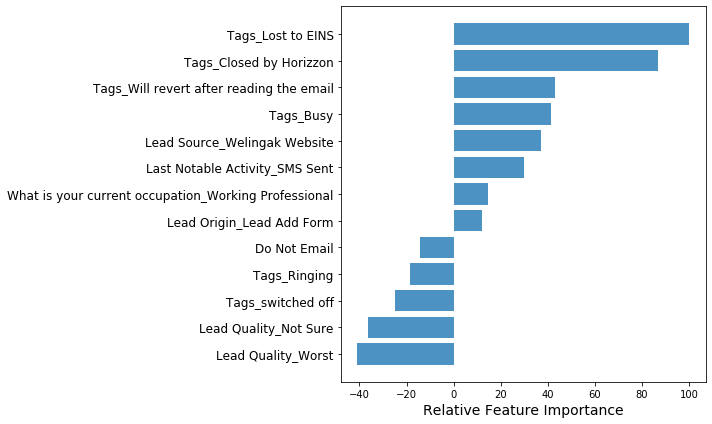

In [136]:
pos = np.arange(sorted_index.shape[0]) + .5

featfig = plt.figure(figsize=(10,6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_index], align='center', color = 'tab:blue',alpha=0.8)
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train[col_list].columns)[sorted_index], fontsize=12)
featax.set_xlabel('Relative Feature Importance', fontsize=14)
plt.tight_layout()   

#### <u>Analysis Summary</u>:
As we can see from the above plot, these are the selected features which are part of our final model which contribute to increasing the probability of lead conversion.

The lead conversion probability increases when there is increase in the below feature value.
- Tags_Lost to EINS
- Tags_Closed by Horizzon
- Tags_Will revert after reading the email
- Tags_Busy
- Lead Source_Welingak Website
- Last Notable Activity_SMS Sent
- What is your current occupation_Working Professional
- What is your current occupation_Unemployed

The lead conversion probability increases when there is decrease in the below feature value.
- Lead Quality_Worst
- Lead Quality_Not Sure
- Tags_switched off
- Tags_Ringing
- Do Not Email

### Step 2: Selecting Top 3 features which contribute most towards lead conversion

In [137]:
# Get the top 3 feature based on feature importance value
pd.DataFrame(feature_importance).reset_index().sort_values(by=0, ascending=False).head(3)

,index,0
6,Tags_Lost to EINS,100.00
5,Tags_Closed by Horizzon,86.68
8,Tags_Will revert after reading the email,43.22


In [138]:
# Also verify the features with negative value to finally decide on Top 3 contributing features for Lead Conversion
pd.DataFrame(feature_importance).reset_index().sort_values(by=0, ascending=True).head(3)

,index,0
11,Lead Quality_Worst,-40.99
10,Lead Quality_Not Sure,-36.40
9,Tags_switched off,-24.93


#### <u>Analysis Summary</u>:
Based on the above results, we can conclude that below three features contribute most to increase the probability of lead conversion.
1. Tags_Lost to EINS
2. Tags_Closed by Horizzon
3. Tags_Will revert after reading the email

<b><u>Note</u></b>: We have considered the probability threshold value of 0.2 based on statistical evaluation. However, based on the business needs, we can either increase or decrease the probability threshold value which will impact the Sensitivity and Specificity of our model. High Sensitivity will ensure that almost all leads who are likely to convert are correctly predicted whereas high Specificity will ensure that leads that are on the edge case are not selected for follow-up.